# KSD Bandwidth sweep

In [87]:
import sys
import os
sys.path.append("/home/lauro/code/msc-thesis/svgd/kernel_learning")
import json_tricks as json
import copy

from tqdm import tqdm
import jax.numpy as np
from jax import grad, jit, vmap, random, lax, jacfwd, value_and_grad
from jax import lax
from jax.ops import index_update, index
import matplotlib.pyplot as plt
import numpy as onp
import jax
import pandas as pd
import haiku as hk
from jax.experimental import optimizers

import config

import utils
import metrics
import time
import plot
import stein
import kernels
import svgd

from jax.experimental import optimizers

key = random.PRNGKey(0)

In [88]:
# initialize kernel, proposal dist, and target dist
def get_rbf_fn(bandwidth):
    logh = np.asarray(bandwidth)
    logh = np.squeeze(bandwidth)
    def rbf(x, y): 
        x, y = np.asarray(x), np.asarray(y)
        return np.exp(- np.sum((x - y)**2 / bandwidth**2) / 2)
    return rbf

proposal = distributions.Gaussian([0,0],1)
target = distributions.Funnel(2)

In [89]:
# comparison kernels
def constant(x, y): return np.array(1.)
def null(x, y): return np.array(0.)
def get_tophat_fn(bandwidth):
    def tophat(x, y): return np.squeeze(np.where(np.linalg.norm(x-y)<bandwidth, 1., 0.))
    return tophat

In [29]:
def ksd_sweep(proposal, target, n=200, m=5, grid=2**np.linspace(-5, 5, 25)):
    ksds_rbf = []
    ksds_top = []
    
    for _ in range(m):
        grid_ksds_rbf = []
        grid_ksds_top = []
        samples = proposal.sample(n)
        for p in tqdm(grid):
            rbf = get_rbf_fn(p)
            tophat = get_tophat_fn(p)
            grid_ksds_rbf.append(stein.ksd_squared_u(samples, target.logpdf, rbf, False))
            grid_ksds_top.append(stein.ksd_squared_u(samples, target.logpdf, tophat, False))
        ksds_rbf.append(grid_ksds_rbf)
        ksds_top.append(grid_ksds_top)
        
    ksds_rbf = np.array(ksds_rbf)
    ksds_top = np.array(ksds_top)

    grid_means_rbf = np.mean(ksds_rbf, axis=0)
    grid_means_top = np.mean(ksds_top, axis=0)

    grid_var_rbf = np.std(ksds_rbf, axis=0)
    grid_var_top = np.std(ksds_top, axis=0)
    return (grid_means_rbf, grid_var_rbf), (grid_means_top, grid_var_top)

(grid_means_rbf, grid_var_rbf), (grid_means_top, grid_var_top) = ksd_sweep(proposal, target)

100%|██████████| 25/25 [00:11<00:00,  2.13it/s]


In [32]:
samples = proposal.sample(400)
ksd_c = stein.ksd_squared_u(samples, target.logpdf, constant, False)

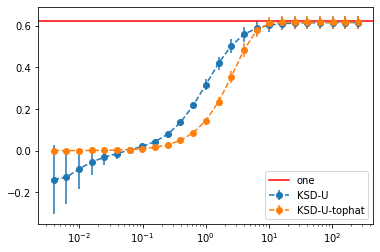

In [33]:
plt.errorbar(grid, grid_means_rbf, yerr=grid_var_rbf, fmt="--o", label="KSD-U")
plt.errorbar(grid, grid_means_top, yerr=grid_var_top, fmt="--o", label="KSD-U-tophat")
plt.axhline(y=ksd_c, label="one", color="r")
plt.xscale("log")
plt.legend()